# **Pneumonia Detection Challenge**

### **Context**

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


###  **Milestone 1 – Pneumonia Classification**

This milestone focuses on classifying whether an X-ray indicates **Lung Opacity**, **Normal**, and **No Lung Opacity / Not Normal**.

| Step  | Task                                                   | Description                                                                                                |
| ----- | ------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------- |
| **1** | **Import the data**                                    | Load all required libraries and read input files: `labels.csv`, `class_info.csv`, `sample_submission.csv`. |
| **2** | **Map training & testing images to its classes**       | Merge datasets using `patientId`, check column info, visualize head & tail.                                |
| **3** | **Map training & testing images to its annotations**   | Extract bounding boxes from DICOM metadata and assign labels `Lung Opacity`, `Normal`, and `No Lung Opacity / Not Normal`.                              |
| **4** | **Preprocessing & visualization of different classes** | Check class distribution, univariate plots, check duplicates, missing data.                                |
| **5** | **Display images with bounding box**                   | Render DICOMs using `pydicom`, validate bounding boxes for Pneumonia class.                                |
| **6** | **Design, train and test basic CNN models**            | Build grayscale CNN (224×224), train & evaluate with early stopping, visualize loss/accuracy/metrics.      |
| **7** | **Interim Report (Milestone 1 Submission)**            | Document insights, model architecture, confusion matrix, and export the notebook.                          |

---

###  **Milestone 2 – Pneumonia Localization (Bounding Box Detection)**

This milestone focuses on localizing the actual **Pneumonia region using object detection**.

| Step  | Task                                               | Description                                                                                   |
| ----- | -------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **1** | **Fine-tune trained CNN model for classification** | Apply class rebalancing, threshold tuning, and data augmentation.                             |
| **2** | **Apply Transfer Learning model (Optional)**       | Use pretrained networks like MobileNet, VGG, or DenseNet.                                        |
| **3** | **Design, train and test RCNN & hybrid models**    | Use models like Faster-RCNN or YOLO to detect bounding boxes for Pneumonia regions.           |
| **4** | **Pickle the model for future prediction**         | Serialize trained classification + detection model using `pickle` or `torch.save`.            |
| **5** | **Final Report (Milestone 2 Submission)**          | Compile all outputs, visualizations, evaluation results, and submit polished notebook/report. |



## **Data Description:** 
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### **Dataset Overview:**

* Images are provided in **DICOM (`.dcm`)** format and include metadata along with pixel data.
* Associated `.csv` files provide:

  * Binary labels (pneumonia or not)
  * Bounding box coordinates (for pneumonia-positive cases)
  * Detailed class categorization: `Lung Opacity`, `Normal`, and `No Lung Opacity / Not Normal`

### **Data Fields**
* patientId _- A patientId. Each patientId corresponds to a unique image.
* x_ - the upper-left x coordinate of the bounding box.
* y_ - the upper-left y coordinate of the bounding box.
* width_ - the width of the bounding box.
* height_ - the height of the bounding box.
* Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.



## **Milestone - 1**

### **Import the Libraries & Data**

In [72]:
# include all the imports here
import os
import io
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom
import random
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, GlobalAveragePooling2D, Input, AveragePooling2D)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers, callbacks
from functools import lru_cache

import warnings
warnings.filterwarnings("ignore")

#### **Loading CSV files**

In [2]:
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'

# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print("-" * 80)
print(train_labels_df.head())
print("\n\nClass Info DataFrame (First 5 rows):")
print("-" * 80)
print(class_info_df.head())


# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print("-" * 80)
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")

print("\n\nClass Info DataFrame Info:")
print("-" * 80)
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")


# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print("-" * 80)
print(train_labels_df.isnull().sum())
print("\n\nMissing values in Class Info DataFrame:")
print("-" * 80)
print(class_info_df.isnull().sum())


# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\n\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print("-" * 80)
print(f"Number of unique patients in Class Info: {unique_patients_class}")
print("-" * 80)

#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', train_labels_df.duplicated().sum())
print("-" * 80)

print('Count of Duplicates: ', class_info_df.duplicated().sum())
print("-" * 80)
df_class_info_clean = class_info_df.drop_duplicates()
print("After dropping duplicates:", df_class_info_clean.shape)


Train Labels DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class Info DataFrame (First 5 rows):
--------------------------------------------------------------------------------
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-4

#### **Train Labels DataFrame Observations**

**Shape:** (30227, 6)

**Columns:** ['patientId', 'x', 'y', 'width', 'height', 'Target']

##### **Data Types:**

**patientId:** object (categorical)

**x, y, width, height:** float (numerical — bounding box coordinates)

**Target:** int (binary classification label: 1 indicates pneumonia, 0 indicates no pneumonia)

##### **Missing Values:**

x, y, width, height have 20,672 missing values each.

patientId and Target have no missing values.

This suggests:

- Only 9,555 images (30227 - 20672) have bounding box annotations.

- Remaining entries without bounding box values (i.e., NaNs) correspond to Target = 0 (no pneumonia).

##### **Notes:**

Each row may represent one bounding box. So a single patient/image may have multiple rows (bounding boxes).

Target = 1 rows typically have bounding boxes; Target = 0 rows do not.

#### **Class Info DataFrame Observations**

**Shape:** (30227, 2)

**Columns:** ['patientId', 'class']

##### **Data Types:**

**patientId:** object (categorical)

**class:** object (categorical classification label)

##### **Class Categories:**

From the sample:

- "No Lung Opacity / Not Normal"

- "Normal"

- "Lung Opacity"

##### **Duplicates:**

3543 duplicate rows were present → Dropped to leave 26684 unique patients.

##### **Cross-Dataset Observations**

After removing duplicates, both DataFrames have 26684 unique patientIds, confirming they refer to the same set of patients.

Train Labels may have multiple entries per patient due to multiple bounding boxes, explaining the row count mismatch.

### **Map Training and Testing Images to Their Classes**

#### Merge the cleaned train_labels and class_info dataframes based on patientId.

In [11]:
# Merge train_labels with class_info to have labels and bounding boxes together
train_data_merged = pd.merge(train_labels_df, df_class_info_clean, on='patientId', how='left')

##### Shape and first few rows of the dataset

In [12]:
# Check merged data
print("Merged DataFrame shape:", train_data_merged.shape)
print(train_data_merged.head())

Merged DataFrame shape: (30227, 7)
                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


##### Statistical Summary of the Dataset

In [20]:
train_data_merged.describe(include = 'all').T

count unique                                   top   freq  \
patientId    30227  26684  3239951b-6211-4290-b237-3d9ad17176db      4   
x           9555.0    NaN                                   NaN    NaN   
y           9555.0    NaN                                   NaN    NaN   
width       9555.0    NaN                                   NaN    NaN   
height      9555.0    NaN                                   NaN    NaN   
Target     30227.0    NaN                                   NaN    NaN   
class        30227      3          No Lung Opacity / Not Normal  11821   

                 mean         std   min    25%    50%    75%    max  
patientId         NaN         NaN   NaN    NaN    NaN    NaN    NaN  
x          394.047724  204.574172   2.0  207.0  324.0  594.0  835.0  
y           366.83956  148.940488   2.0  249.0  365.0  478.5  881.0  
width      218.471376   59.289475  40.0  177.0  217.0  259.0  528.0  
height     329.269702  157.750755  45.0  203.0  298.0  438.0  942.0  
Target       0.316108    0.464963   0.0    0.0    0.0    1.0    1.0  
class             NaN         NaN   NaN    NaN    NaN    NaN    NaN

##### Missing Values

In [21]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0],
              'Percentage':(train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0]/train_data_merged.shape[0])*100})

Count  Percentage
x       20672   68.389188
y       20672   68.389188
width   20672   68.389188
height  20672   68.389188

#### Inspect the distribution of class labels


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


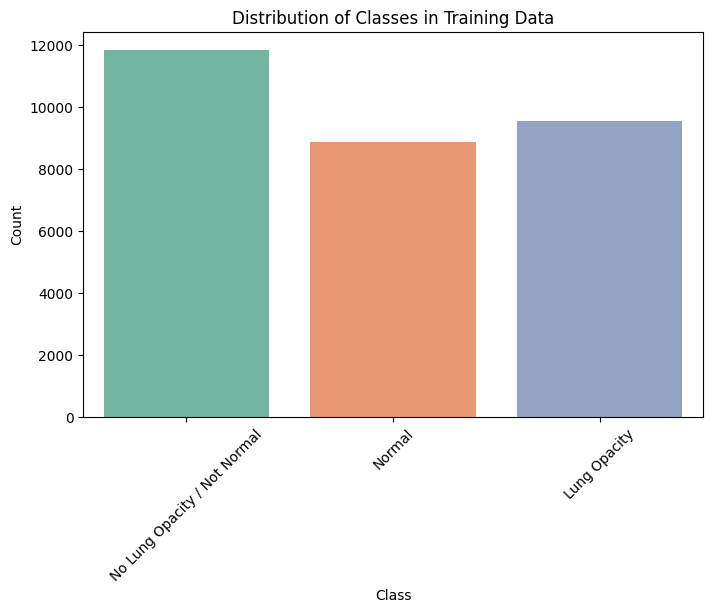

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='Set2', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


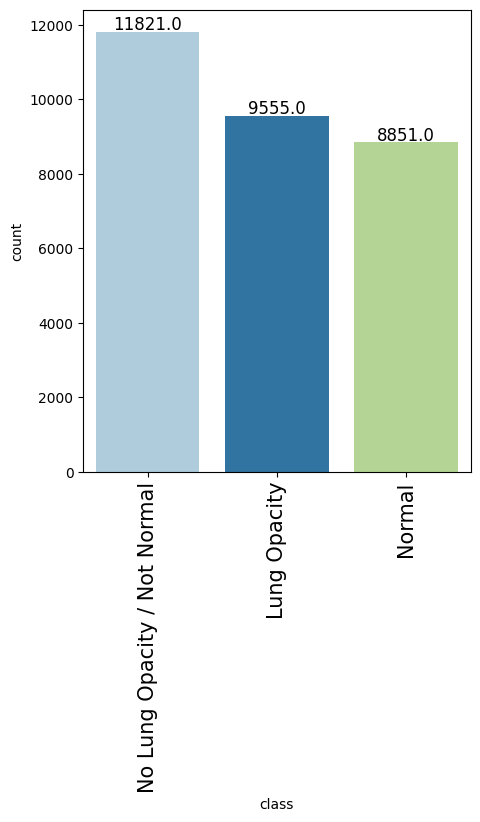

In [23]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

labeled_barplot(train_data_merged, "class")

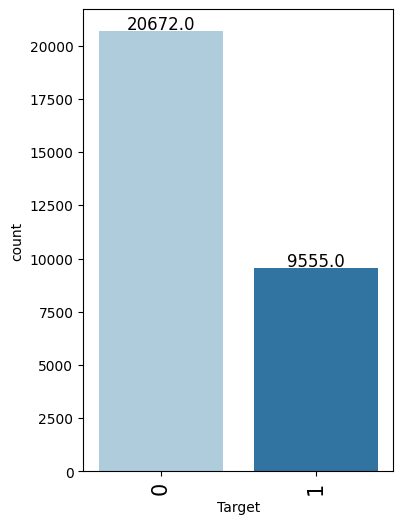

In [24]:
labeled_barplot(train_data_merged, "Target")

### **Map Training Images to Their Annotations**

#### Map patient IDs to their bounding boxes

In [25]:
# Group annotations by patientId clearly
annotations_grouped = train_data_merged.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_data_merged[train_data_merged['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))



Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target  \
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   

          class  
4  Lung Opacity  
5  Lung Opacity  


#### Create a convenient annotation dictionary

In [26]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])


Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


#### Summary of Bounding Box Data

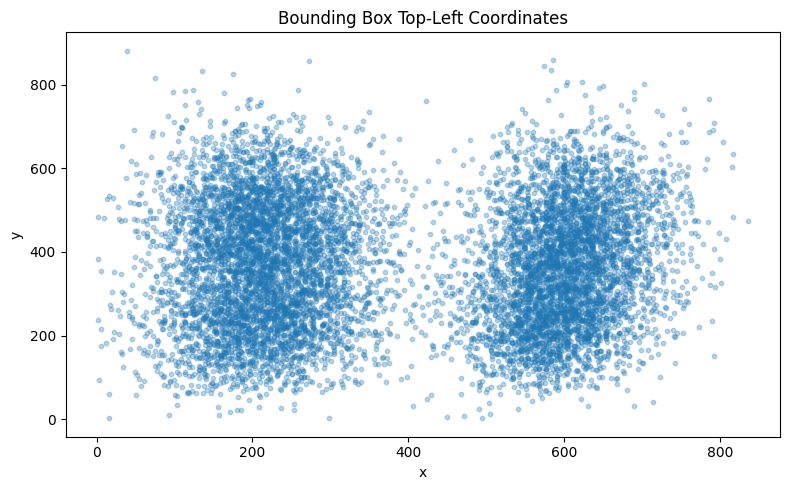

In [29]:
# Bounding boxes co-ordinates
plt.figure(figsize=(8, 5))
pneumonia_boxes = train_data_merged[train_data_merged['Target'] == 1]
plt.scatter(pneumonia_boxes['x'], pneumonia_boxes['y'], alpha=0.3, s=10)
plt.title("Bounding Box Top-Left Coordinates")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### Step 4: Preprocessing and Visualization of Different Classes

In [34]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, img_size=(224, 224)):
    """
    Load and preprocess a DICOM image for a given patient ID

    Parameters:
    - patient_id: ID of the patient
    - img_size: Tuple of (height, width) for resizing

    Returns:
    - Preprocessed image as numpy array
    """
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    # Convert to numpy array
    image = dicom.pixel_array

    # Normalize pixel values to be between 0 and 1
    image = image / np.max(image)

    # Convert to grayscale if necessary
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    image = cv2.resize(image, img_size[::-1])

    # Expand dimensions for CNN input (add channel dimension)
    image = np.expand_dims(image, axis=-1)

    return image

In [35]:
# Sample a few images from each class for visualization
def sample_patients_from_class(class_name, n=4):
    """Sample n patient IDs from a given class"""
    return random.sample(list(train_data_merged[train_data_merged['class'] == class_name]['patientId']), n)

# Sample patient IDs from each class
normal_patients = sample_patients_from_class('Normal',3)
opacity_patients = sample_patients_from_class('Lung Opacity',3)
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal',3)

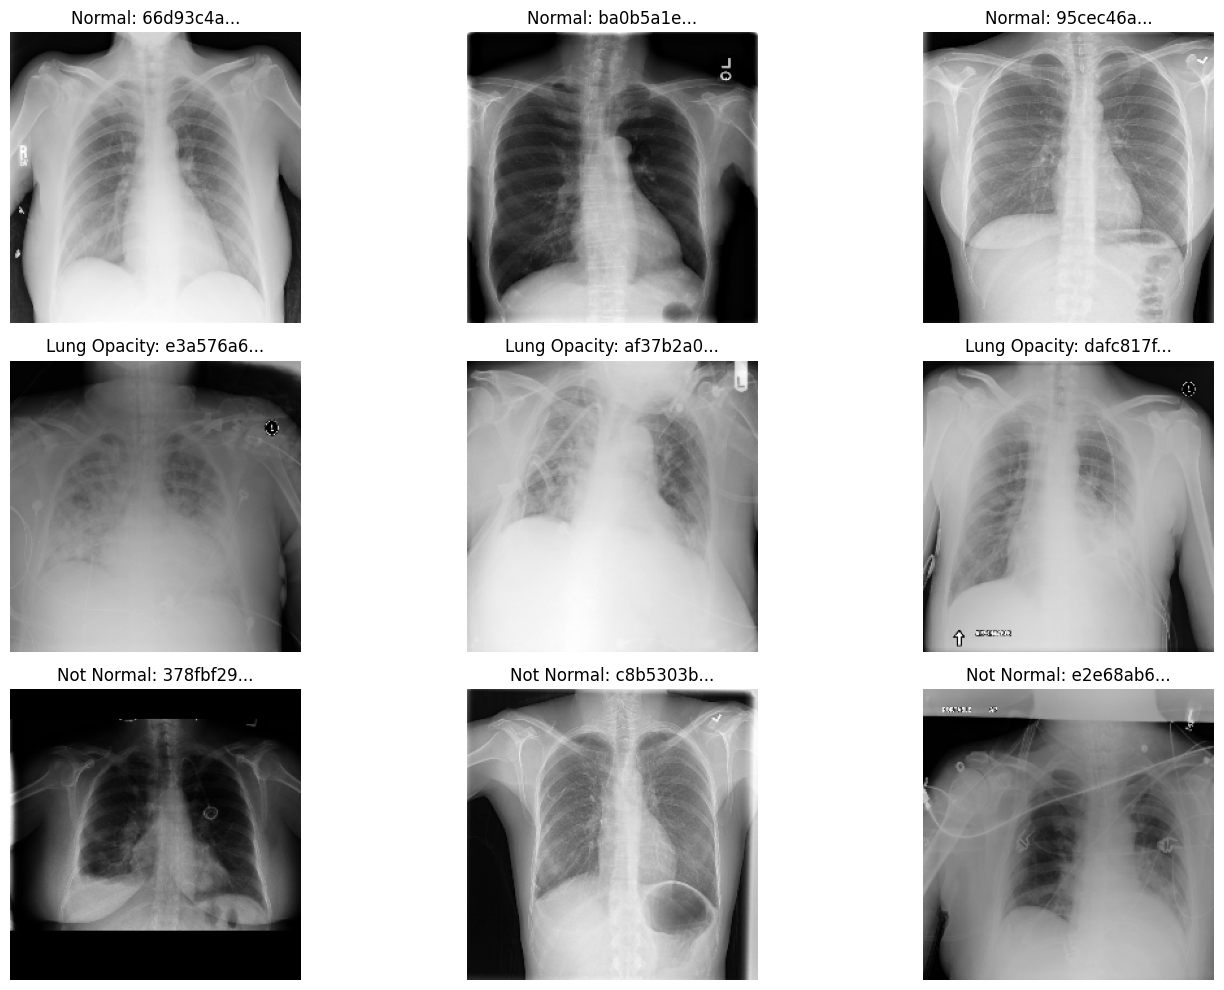

In [38]:
# Plot sample images from each class
plt.figure(figsize=(15, 10))

# Plot Normal images
for i, patient_id in enumerate(normal_patients):
    plt.subplot(3, 3, i+1)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Normal: {patient_id[:8]}...")
    plt.axis('off')

# Plot Lung Opacity images
for i, patient_id in enumerate(opacity_patients):
    plt.subplot(3, 3, i+4)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Lung Opacity: {patient_id[:8]}...")
    plt.axis('off')

# Plot Not Normal No Lung Opacity images
for i, patient_id in enumerate(not_normal_patients):
    plt.subplot(3, 3, i+7)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Not Normal: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [39]:
# Function to load DICOM image with original size
def load_original_dicom(patient_id):
    """Load DICOM image without resizing"""
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    image = dicom.pixel_array
    image = image / np.max(image)
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [40]:
# Function to draw bounding boxes on image
def draw_boxes(image, boxes):
    """Draw bounding boxes on the image"""

    # Ensure image is in uint8 format (0-255)
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # Convert grayscale image to RGB for colored boxes
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for box in boxes:
        x, y = int(box['x']), int(box['y'])
        w, h = int(box['width']), int(box['height'])
        image_color = cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_color

In [48]:
# Create a mapping of patient IDs to their respective bounding boxes
patient_boxes = {}
for index, row in train_data_merged.iterrows():
    patient_id = row['patientId']
    target = row['Target']

    if target == 1:  # Only consider rows with Target=1 (has bounding box)
        if patient_id not in patient_boxes:
            patient_boxes[patient_id] = []

        # Add bounding box coordinates
        patient_boxes[patient_id].append({
            'x': row['x'],
            'y': row['y'],
            'width': row['width'],
            'height': row['height']
        })
        
# Sample a few patients with Lung Opacity (which have bounding boxes)
opacity_patients = sample_patients_from_class('Lung Opacity')
opacity_with_boxes = [pid for pid in opacity_patients if pid in patient_boxes]

if not opacity_with_boxes:
    opacity_with_boxes = list(set(patient_boxes.keys()) &
                             set(train_data_merged[train_data_merged['class'] == 'Lung Opacity']['patientId']))[:4]


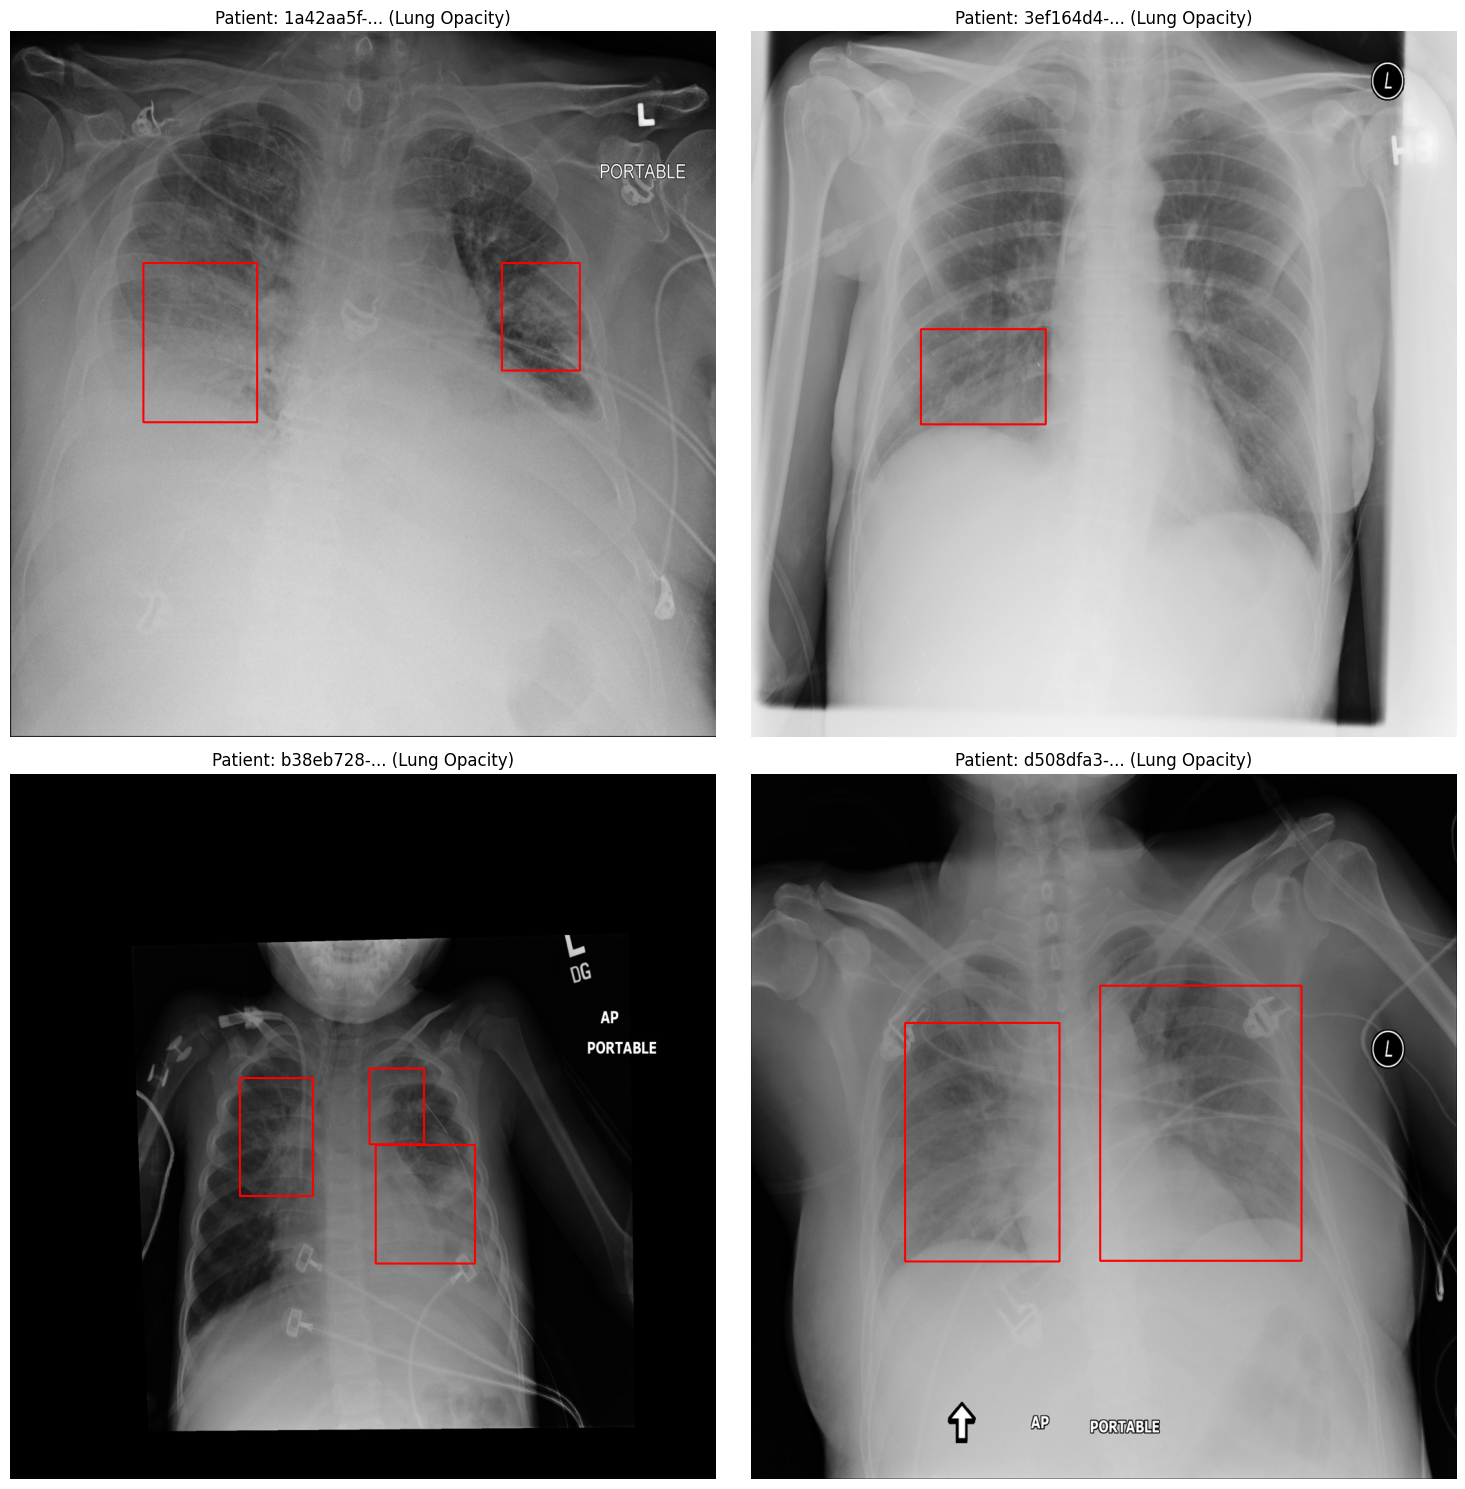

In [49]:
# Plot images with bounding boxes
plt.figure(figsize=(15, 15))

for i, patient_id in enumerate(opacity_with_boxes[:4]):
    try:
        plt.subplot(2, 2, i + 1)
        img = load_original_dicom(patient_id)

        if img is None:
            print(f"[Warning] Image for patient {patient_id} is None.")
            continue

        if patient_id in patient_boxes:
            img_with_boxes = draw_boxes(img, patient_boxes[patient_id])
            plt.imshow(img_with_boxes, cmap='gray')
        else:
            plt.imshow(img, cmap='gray')

        plt.title(f"Patient: {patient_id[:9]}... (Lung Opacity)")
        plt.axis('off')

    except Exception as e:
        print(f"[Error] Failed on patient {patient_id}: {e}")

plt.tight_layout()
plt.show()


#### **Inspect Class Distribution**

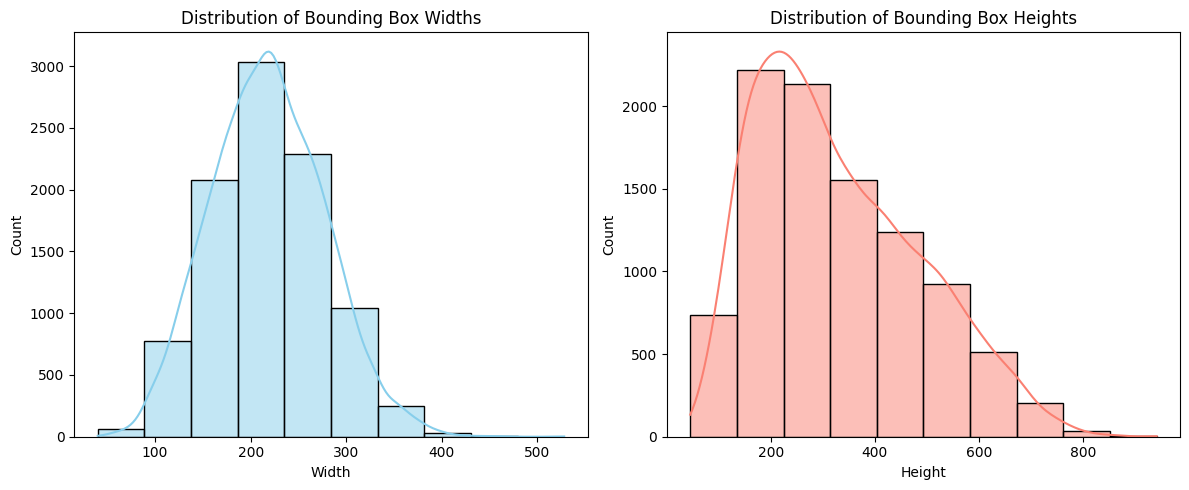

In [44]:
# Visualize distribution of bounding box dimensions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(train_data_merged['width'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')

plt.subplot(1,2,2)
sns.histplot(train_data_merged['height'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')

plt.tight_layout()
plt.show()


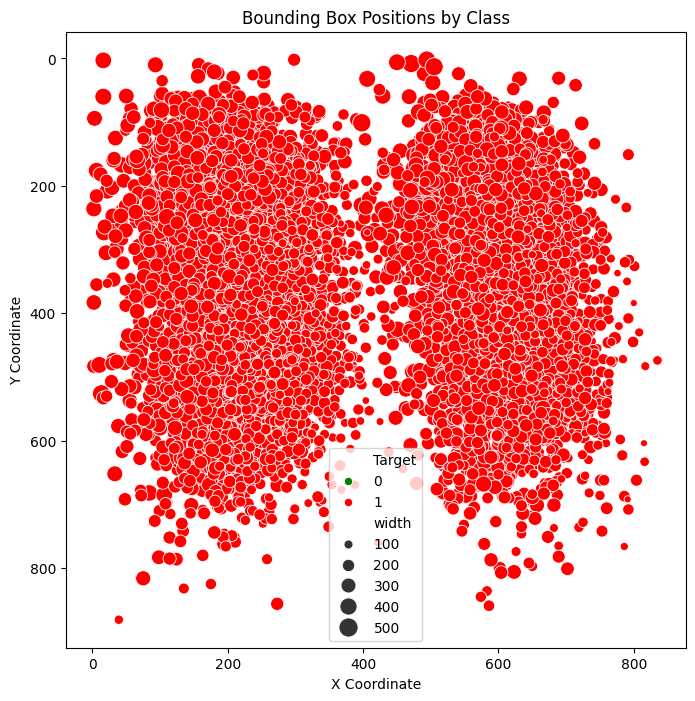

In [45]:
# Create a scatter plot of bounding box positions
plt.figure(figsize=(8,8))
sns.scatterplot(
    x='x', y='y',
    hue='Target',
    size='width', sizes=(20, 200),
    data=train_data_merged, palette=['green', 'red']
)
plt.title('Bounding Box Positions by Class')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
plt.show()

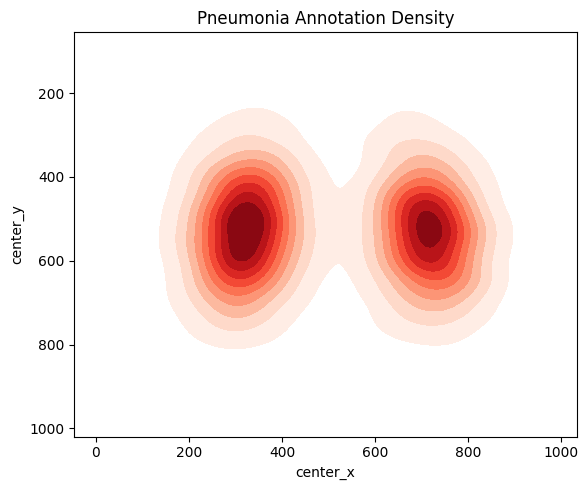

In [ ]:
# Calculate centers of bounding boxes
train_data_merged['center_x'] = train_data_merged['x'] + train_data_merged['width']/2
train_data_merged['center_y'] = train_data_merged['y'] + train_data_merged['height']/2

# Create separate DataFrames for each class
pneumonia_df = train_data_merged[train_data_merged['Target'] == 1]

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.kdeplot(x=pneumonia_df['center_x'], y=pneumonia_df['center_y'],
            cmap='Reds', fill=True)
plt.title('Pneumonia Annotation Density')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### **Design, Train, and Test Basic CNN Models**

#### **Encode Labels and Prepare Train/Validation Split**

In [13]:
# Prepare class labels
le = LabelEncoder()
train_data_merged['label'] = le.fit_transform(train_data_merged['class'])

# Train/Validation split
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_data_merged['patientId'], train_data_merged['label'], stratify=train_data_merged['label'], test_size=0.2, random_state=42)


#### **Data Generators**

In [14]:
class DicomProcessorFromZip:
    def __init__(self, zip_path: str):
        self.zip_path = zip_path
        self.zip_file = zipfile.ZipFile(zip_path, 'r')  # open once and keep handle

    def get_file_bytes(self, patient_id: str) -> bytes:
        # Assuming files are named like 'patientId.dcm' inside the zip
        file_name = f"stage_2_train_images/{patient_id}.dcm"
        try:
            with self.zip_file.open(file_name) as file:
                data = file.read()
            return data
        except KeyError:
            raise FileNotFoundError(f"{file_name} not found in ZIP archive")

    def read_dicom_file(self, patient_id: str) -> np.ndarray:
        dicom_bytes = self.get_file_bytes(patient_id)
        dicom_io = io.BytesIO(dicom_bytes)
        ds = pydicom.dcmread(dicom_io)
        return ds.pixel_array

    def convert_to_grayscale(self, image: np.ndarray) -> np.ndarray:
        # Normalize pixel values to [0, 1]
        image = image / np.max(image)

        # Convert to grayscale if image has multiple channels
        if image.ndim > 2:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        return image

    def get_resized_dicom_image(self, patient_id: str, size=256) -> np.ndarray:
        # Read DICOM image from ZIP
        image = self.read_dicom_file(patient_id)

        # Convert to grayscale and normalize
        image = self.convert_to_grayscale(image)

        # Resize image
        image = cv2.resize(image, (size, size))

        # Add channel dimension for CNN input
        image = np.expand_dims(image, axis=-1)

        return image

    def close(self):
        self.zip_file.close()

In [15]:
# Loading test and training images
test_images = DicomProcessorFromZip('stage_2_test_images.zip')
train_images = DicomProcessorFromZip('stage_2_train_images.zip')

In [59]:
class PneumoniaDataGenerator(Sequence):
    def __init__(self, patient_ids, labels, processor, batch_size=32, image_size=256, shuffle=True):
        self.patient_ids = list(patient_ids)
        self.labels = list(labels)
        self.processor = processor
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.patient_ids) // self.batch_size

    def __getitem__(self, index):
        ids = self.patient_ids[index * self.batch_size:(index + 1) * self.batch_size]
        y = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.array([self.processor.get_resized_dicom_image(pid, size=self.image_size) for pid in ids])
        y = to_categorical(y, num_classes=3)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.patient_ids, self.labels))
            random.shuffle(temp)
            self.patient_ids, self.labels = zip(*temp)
    
    def reset(self):
        self.on_epoch_end()


In [58]:
class MobileNetDataGenerator(PneumoniaDataGenerator):
    def __getitem__(self, index):
        X, y = super().__getitem__(index)
        X = np.repeat(X[..., np.newaxis], 3, axis=-1) if X.ndim == 3 else np.repeat(X, 3, axis=-1)  # convert (H, W, 1) -> (H, W, 3)
        return X, y


In [24]:
def setup_callbacks(model_name='pneumonia_model_best'):
    """Setup optimized training callbacks"""
    return [
        callbacks.ModelCheckpoint(
            f'{model_name}.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1,
            save_weights_only=False
        ),
        callbacks.EarlyStopping(
            patience=5,
            monitor='val_loss',
            restore_best_weights=True,
            verbose=1,
            min_delta=0.001
        ),
        callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            monitor='val_loss',
            verbose=1,
            cooldown=2
        ),
        callbacks.TerminateOnNaN()
    ]

#### **Model Builder**

In [60]:
class ModelBuilder:
    def __init__(self, input_shape, num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_basic_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_deeper_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Dropout(0.1),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Dropout(0.2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Dropout(0.3),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_lenet5(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Conv2D(6, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(120, activation='tanh'),
            Dense(84, activation='tanh'),
            Dense(self.num_classes, activation='softmax')
        ])
        return model
        
    def build_mobilenetv2(self):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        base_model.trainable = False

        inputs = Input(shape=(256, 256, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model


#### **TrainingManager**

In [61]:
class TrainingManager:
    def __init__(self, processor, train_ids, train_labels, val_ids, val_labels, batch_size=32):
        self.processor = processor
        self.train_ids = train_ids
        self.train_labels = train_labels
        self.val_ids = val_ids
        self.val_labels = val_labels
        self.batch_size = batch_size

    def get_generator(self, model_type):
        if model_type == 'MobileNetV2':
            return (
                MobileNetDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                MobileNetDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )
        else:
            return (
                PneumoniaDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                PneumoniaDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )

    def train_model(self, model_type: str, epochs=5):
        input_shape = (256, 256, 1) if model_type != 'MobileNetV2' else (256, 256, 3)
        builder = ModelBuilder(input_shape=input_shape)

        if model_type == 'BasicCNN':
            model = builder.build_basic_cnn()
        elif model_type == 'DeeperCNN':
            model = builder.build_deeper_cnn()
        elif model_type == 'MobileNetV2':
            model = builder.build_mobilenetv2()
        elif model_type == 'LeNet5':
            model = builder.build_lenet5()
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        model.compile(optimizer=optimizers.Adam(
                                    learning_rate=1e-4,
                                    beta_1=0.9,
                                    beta_2=0.999,
                                    epsilon=1e-7
                                ), 
                                loss='categorical_crossentropy', metrics=['accuracy'])
        print(model.summary())
        
        callback_list = setup_callbacks()

        train_gen, val_gen = self.get_generator(model_type)

        print(f"Training: {model_type}")
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs,callbacks=callback_list,verbose=1)
        return model, history, val_gen


In [30]:
def plot_training_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [66]:
def evaluate_model(model, val_generator, label_encoder):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report, confusion_matrix

    print("Evaluating model performance...")

    y_true, y_pred = [], []
    batch_count = 0

    try:
               
        # Iterate through validation generator
        for i in range(len(val_generator)):
            batch_x, batch_y = val_generator[i]
            
            # Make predictions
            preds = model.predict(batch_x, verbose=0)
            
            # Convert from one-hot to label indices
            y_true.extend(np.argmax(batch_y, axis=1))
            y_pred.extend(np.argmax(preds, axis=1))
            
            batch_count += 1
            
            # Optional: Print progress for large datasets
            if batch_count % 10 == 0:
                print(f"Processed {batch_count} batches...")
    
    except Exception as e:
        print(f"Error during prediction: {e}")
        print("Trying alternative approach...")
        
        # Alternative approach: use model.evaluate and manual iteration
        try:
            
            for batch_x, batch_y in val_generator:
                if len(batch_x) == 0:  # Skip empty batches
                    continue
                    
                preds = model.predict(batch_x, verbose=0)
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(np.argmax(preds, axis=1))
                
                batch_count += 1
                if batch_count >= len(val_generator):
                    break
                    
        except Exception as e2:
            print(f"Alternative approach also failed: {e2}")
            return None, None

    # Check if we have any predictions
    if len(y_true) == 0 or len(y_pred) == 0:
        print("No predictions were made. Check your validation generator.")
        print(f"Generator length: {len(val_generator)}")
        print(f"Batch count processed: {batch_count}")
        return None, None

    print(f"Successfully processed {len(y_true)} samples from {batch_count} batches")

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Decode to original string labels
    try:
        y_true_labels = label_encoder.inverse_transform(y_true)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
        class_names = label_encoder.classes_
    except Exception as e:
        print(f"Error with label encoder: {e}")
        print("Using numeric labels instead...")
        y_true_labels = y_true
        y_pred_labels = y_pred
        class_names = np.unique(np.concatenate([y_true, y_pred]))

    # Print classification report
    print("\nClassification Report:")
    print("=" * 50)
    print(classification_report(y_true_labels, y_pred_labels, target_names=[str(name) for name in class_names], digits=4))

    # Create confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels, labels=class_names)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return y_true_labels, y_pred_labels

In [50]:
def display_sample_predictions(model, dataset, label_encoder, num_samples=8):

    class_names = label_encoder.classes_

    # Get the first batch
    images, labels = dataset[0]  # Access first batch

    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels, axis=1)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        axes[i].axis('off')

        true_label = label_encoder.inverse_transform([true_classes[i]])[0]
        pred_label = label_encoder.inverse_transform([pred_classes[i]])[0]
        confidence = np.max(preds[i]) * 100
        color = 'green' if true_label == pred_label else 'red'

        axes[i].set_title(
            f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%',
            color=color, fontweight='bold'
        )

    plt.tight_layout()
    plt.show()

In [33]:
@lru_cache(maxsize=1000)
def decode_dicom_image_cached(patient_id, img_size=(224, 224)):
    """Cached version of DICOM image decoding for faster repeated access"""
    return decode_dicom_image(patient_id, img_size)

def decode_dicom_image(patient_id, img_size=(224, 224)):
    """Optimized DICOM image decoding with error handling"""
    zip_path = 'stage_2_train_images.zip'

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_archive:
            dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

            if dicom_filename not in zip_archive.namelist():
                raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

            with zip_archive.open(dicom_filename) as file:
                dicom_bytes = file.read()
                dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

        # Optimized image processing
        image = dicom.pixel_array.astype(np.float32)

        # Robust normalization
        image_min, image_max = image.min(), image.max()
        if image_max > image_min:
            image = (image - image_min) / (image_max - image_min)
        else:
            image = np.zeros_like(image)

        # Convert to uint8 and resize efficiently
        image = (image * 255).astype(np.uint8)

        # Use PIL for efficient resizing
        pil_image = Image.fromarray(image)
        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')

        pil_image = pil_image.resize(img_size, Image.LANCZOS)
        image = np.array(pil_image, dtype=np.float32) / 255.0

        return image

    except Exception as e:
        print(f"Error processing {patient_id}: {e}")
        # Return a blank image in case of error
        return np.zeros((img_size[0], img_size[1], 3), dtype=np.float32)

In [34]:
def create_data_augmentation():
    def augment_fn(image):
        image = tf.cast(image, tf.float32)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.1)
        image = tf.image.random_contrast(image, 0.9, 1.1)
        image = tf.image.random_saturation(image, 0.9, 1.1)
        return image

    return tf.keras.layers.Lambda(lambda x: augment_fn(x))


#### **Train And Evaluate Models**

In [35]:
trainer = TrainingManager(
    processor=train_images,
    train_ids=train_ids,
    train_labels=train_labels,
    val_ids=val_ids,
    val_labels=val_labels
)


In [38]:
#Train and Evaludate Basic CNN model
basic_model, basic_history, basic_val_gen = trainer.train_model(model_type='BasicCNN', epochs=10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,838,787 (56.61 MB)

 Trainable params: 14,838,787 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

None
Training: BasicCNN
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4940 - loss: 0.9753
Epoch 1: val_accuracy improved from -inf to 0.59807, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.4941 - loss: 0.9753 - val_accuracy: 0.5981 - val_loss: 0.8422 - learning_rate: 1.0000e-04
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5808 - loss: 0.8694
Epoch 2: val_accuracy improved from 0.59807 to 0.60805, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 1060s 1s/step - accuracy: 0.5808 - loss: 0.8694 - val_accuracy: 0.6080 - val_loss: 0.8272 - learning_rate: 1.0000e-04
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5887 - loss: 0.8521
Epoch 3: val_accuracy improved from 0.60805 to 0.62849, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 1036s 1s/step - accuracy: 0.5887 - loss: 0.8521 - val_accuracy: 0.6285 - val_loss: 0.7984 - learning_rate

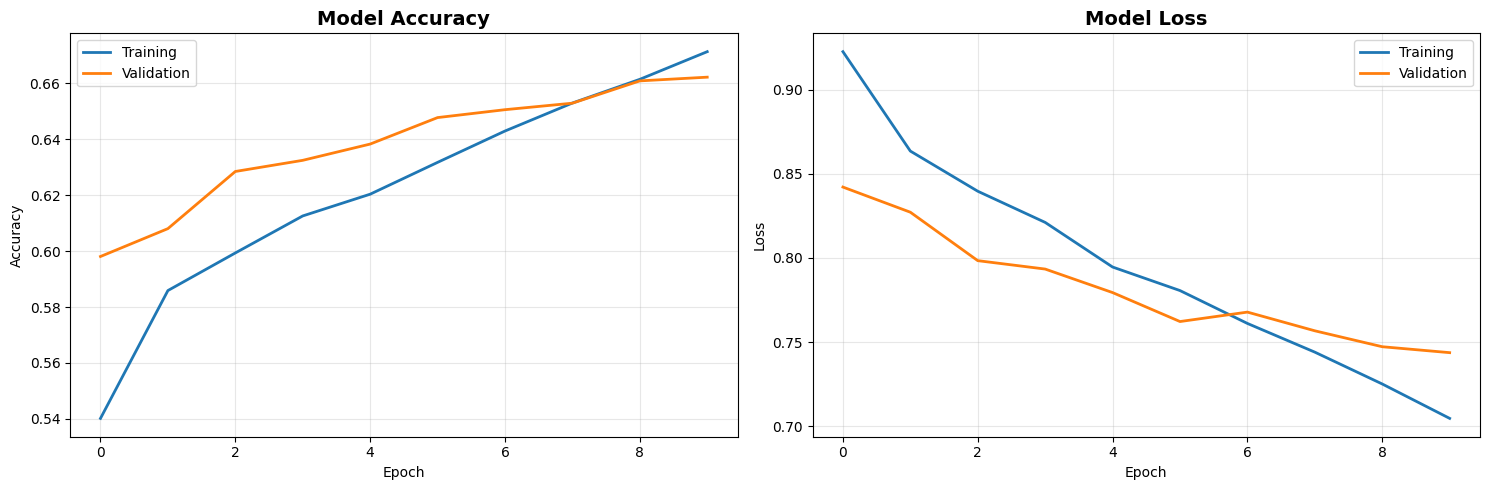

In [40]:
# Plot training history
plot_training_history(basic_history)

In [44]:
# Evaluate on validation generator
val_loss, val_acc = basic_model.evaluate(basic_val_gen)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 432ms/step - accuracy: 0.6628 - loss: 0.7497
Validation Loss: 0.7411, Validation Accuracy: 0.6639


Evaluating model performance...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Successfully processed 6016 samples from 188 batches

Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.6957    0.6625    0.6787      1902
No Lung Opacity / Not Normal     0.6086    0.5607    0.5837      2354
                      Normal     0.6920    0.8006    0.7424      1760

                    accuracy                         0.6631      6016
                   macro avg     0.6655    0.6746    0.6682      6016
                weighted avg

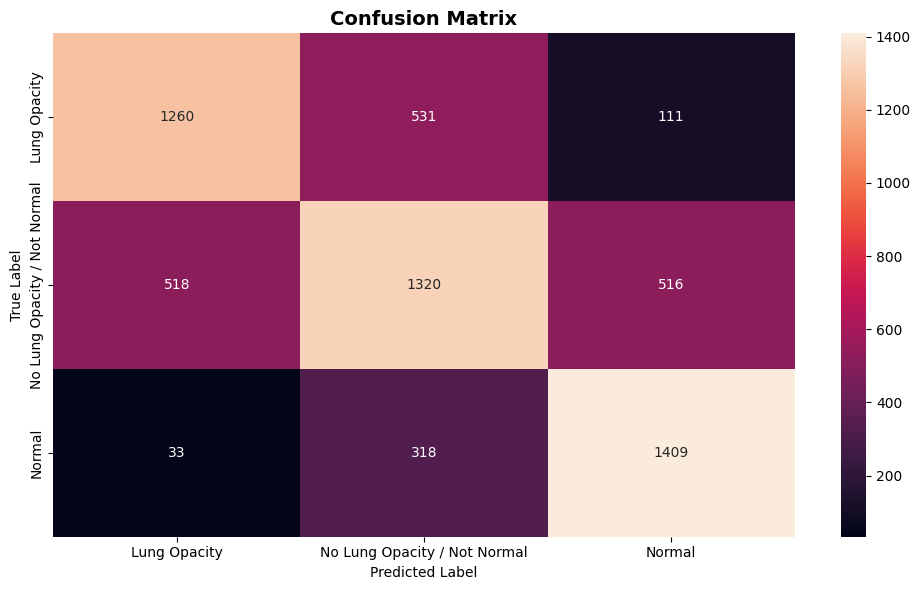

In [68]:
# Evaluate model using label encoder
y_true, y_pred = evaluate_model(basic_model, basic_val_gen, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


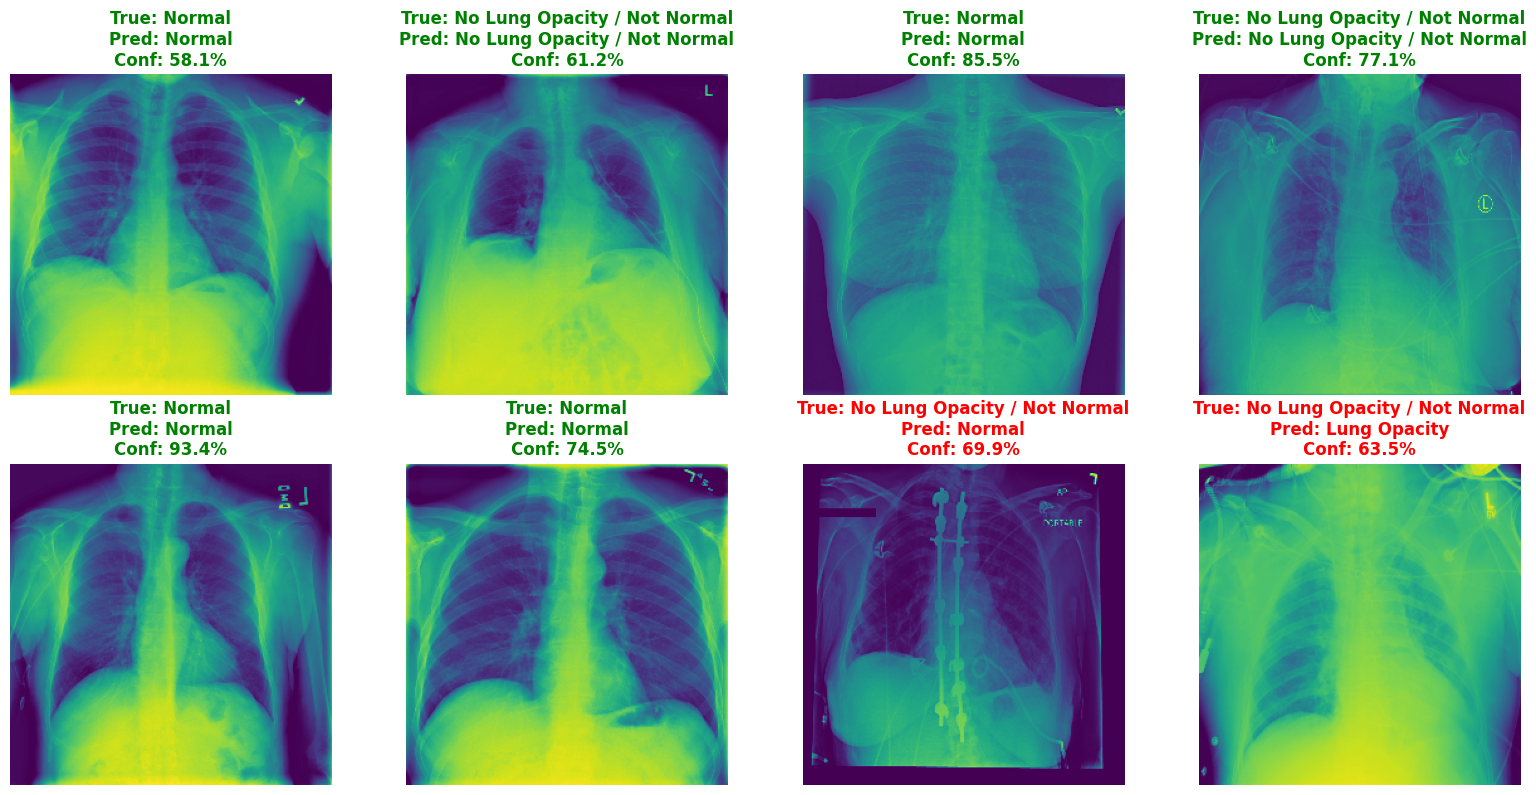

In [ ]:
# Display predictions
display_sample_predictions(basic_model, basic_val_gen, le)

In [53]:
#Train MobileNetV2 model
mobilenet_model, mobilenet_history, mobilenet_val_gen = trainer.train_model(model_type='MobileNetV2', epochs=10)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Training: MobileNetV2
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.5697 - loss: 0.8660
Epoch 1: val_accuracy improved from -inf to 0.65658, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 641s 844ms/step - accuracy: 0.5698 - loss: 0.8659 - val_accuracy: 0.6566 - val_loss: 0.7350 - learning_rate: 1.0000e-04
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6595 - loss: 0.7260
Epoch 2: val_accuracy improved from 0.65658 to 0.67653, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 665s 881ms/step - accuracy: 0.6595 - loss: 0.7260 - val_accuracy: 0.6765 - val_loss: 0.7096 - learning_rate: 1.0000e-04
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - accuracy: 0.6789 - loss: 0.6994
Epoch 3: val_accuracy did not improve from 0.67653
755/755 ━━━━━━━━━━━━━━━━━━━━ 679s 899ms/step - accuracy: 0.6789 - loss: 0.6994 - val_accuracy: 0.6760 - val_loss: 0.7047 - learning_rate: 1.0000e-04
Epoch 4/10
755/7

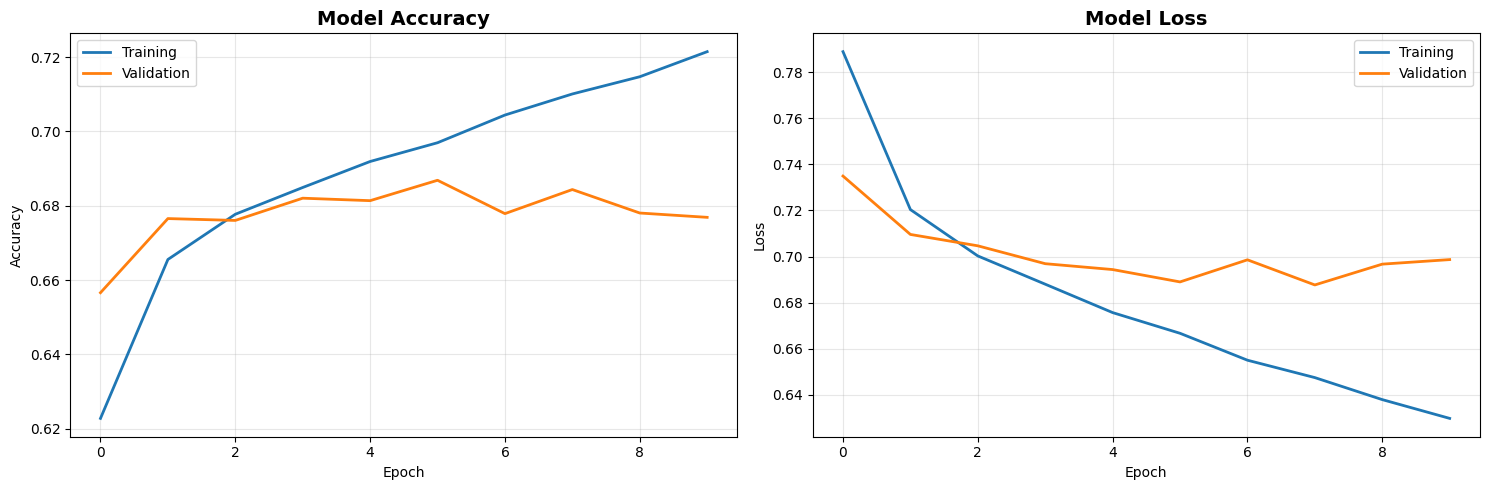

In [54]:
# Plot training history
plot_training_history(mobilenet_history)

Evaluating model performance...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Successfully processed 6016 samples from 188 batches

Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.6814    0.6979    0.6896      1897
No Lung Opacity / Not Normal     0.6301    0.5714    0.5993      2352
                      Normal     0.7464    0.8195    0.7812      1767

                    accuracy                         0.6842      6016
                   macro avg     0.6860    0.6963    0.6900      6016
                weighted avg

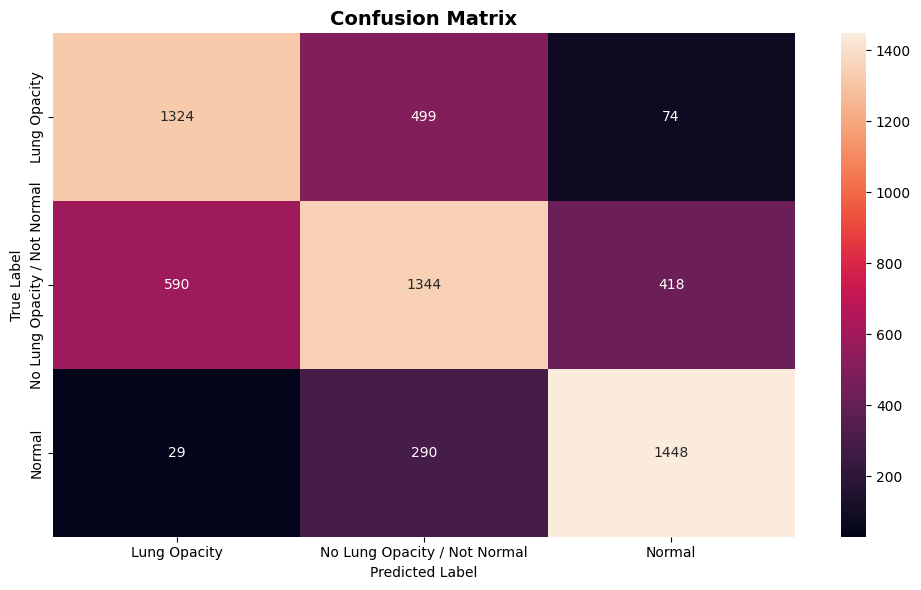

In [67]:
# Evaluate model using label encoder
y_true, y_pred = evaluate_model(mobilenet_model, mobilenet_val_gen, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


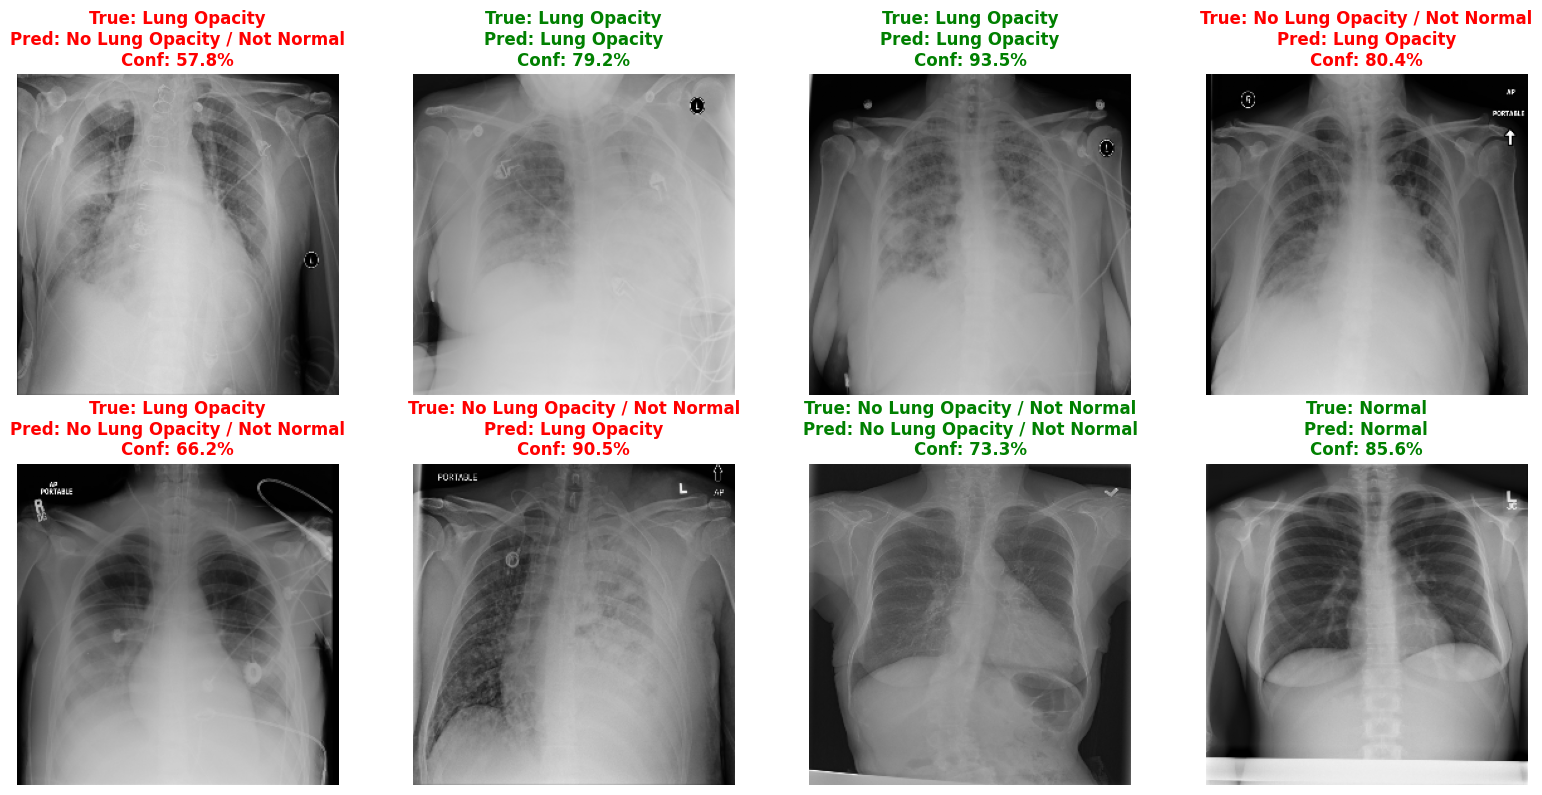

In [69]:
# Display predictions
display_sample_predictions(mobilenet_model, mobilenet_val_gen, le)

In [73]:
#Train and Evaludate LeNet5 model
lenet5_model, lenet5_history, lenet5_val_gen= trainer.train_model(model_type='LeNet5', epochs=10)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 252, 252, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 126, 126, 6)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 122, 122, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 61, 61, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 59536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │     7,144,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,157,431 (27.30 MB)

 Trainable params: 7,157,431 (27.30 MB)

 Non-trainable params: 0 (0.00 B)

None
Training: LeNet5
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.5086 - loss: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.57330, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 336s 443ms/step - accuracy: 0.5086 - loss: 0.9813 - val_accuracy: 0.5733 - val_loss: 0.8599 - learning_rate: 1.0000e-04
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5893 - loss: 0.8549
Epoch 2: val_accuracy improved from 0.57330 to 0.60106, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 328s 434ms/step - accuracy: 0.5893 - loss: 0.8549 - val_accuracy: 0.6011 - val_loss: 0.8289 - learning_rate: 1.0000e-04
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.6138 - loss: 0.8124
Epoch 3: val_accuracy improved from 0.60106 to 0.60406, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 332s 440ms/step - accuracy: 0.6138 - loss: 0.8124 - val_accuracy: 0.6041 - val_loss: 0.8232 -

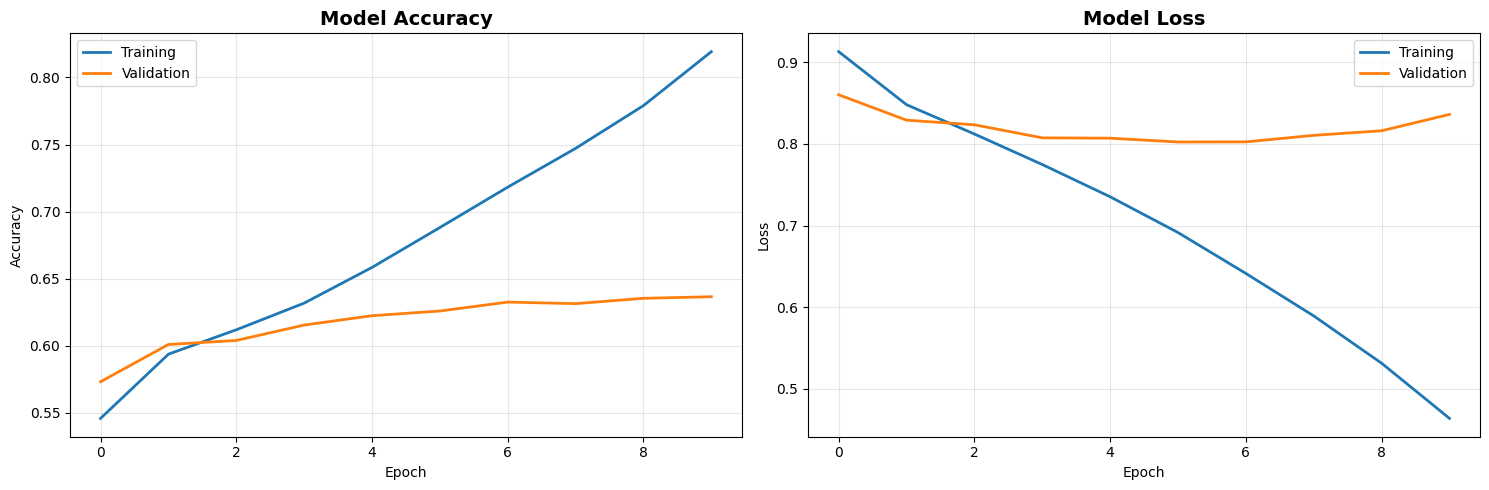

In [74]:
# Plot training history
plot_training_history(lenet5_history)

Evaluating model performance...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Successfully processed 6016 samples from 188 batches

Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.6559    0.6845    0.6699      1902
No Lung Opacity / Not Normal     0.6007    0.4235    0.4968      2352
                      Normal     0.6174    0.8314    0.7086      1762

                    accuracy                         0.6255      6016
                   macro avg     0.6247    0.6465    0.6251      6016
                weighted avg

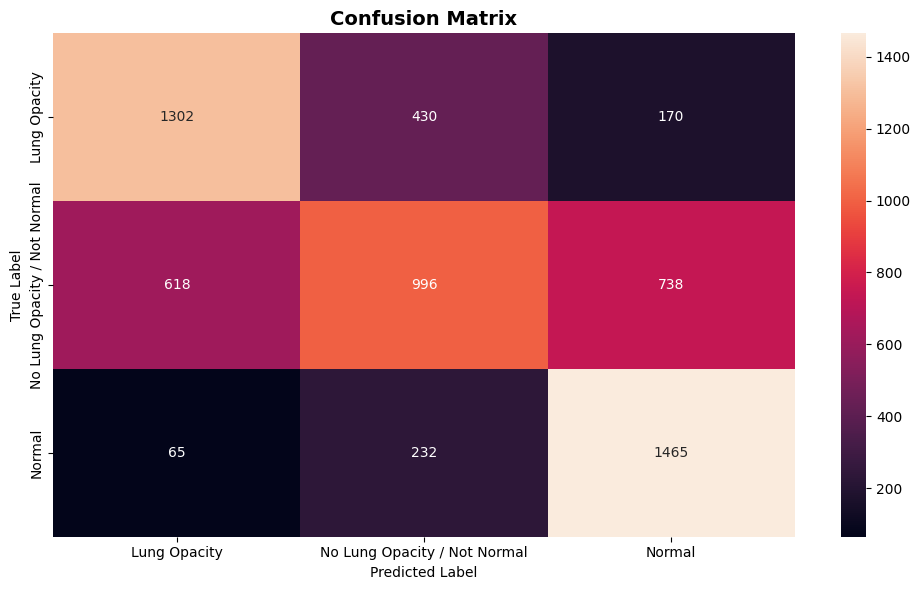

In [76]:
# Evaluate model using label encoder
y_true, y_pred = evaluate_model(lenet5_model, lenet5_val_gen, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


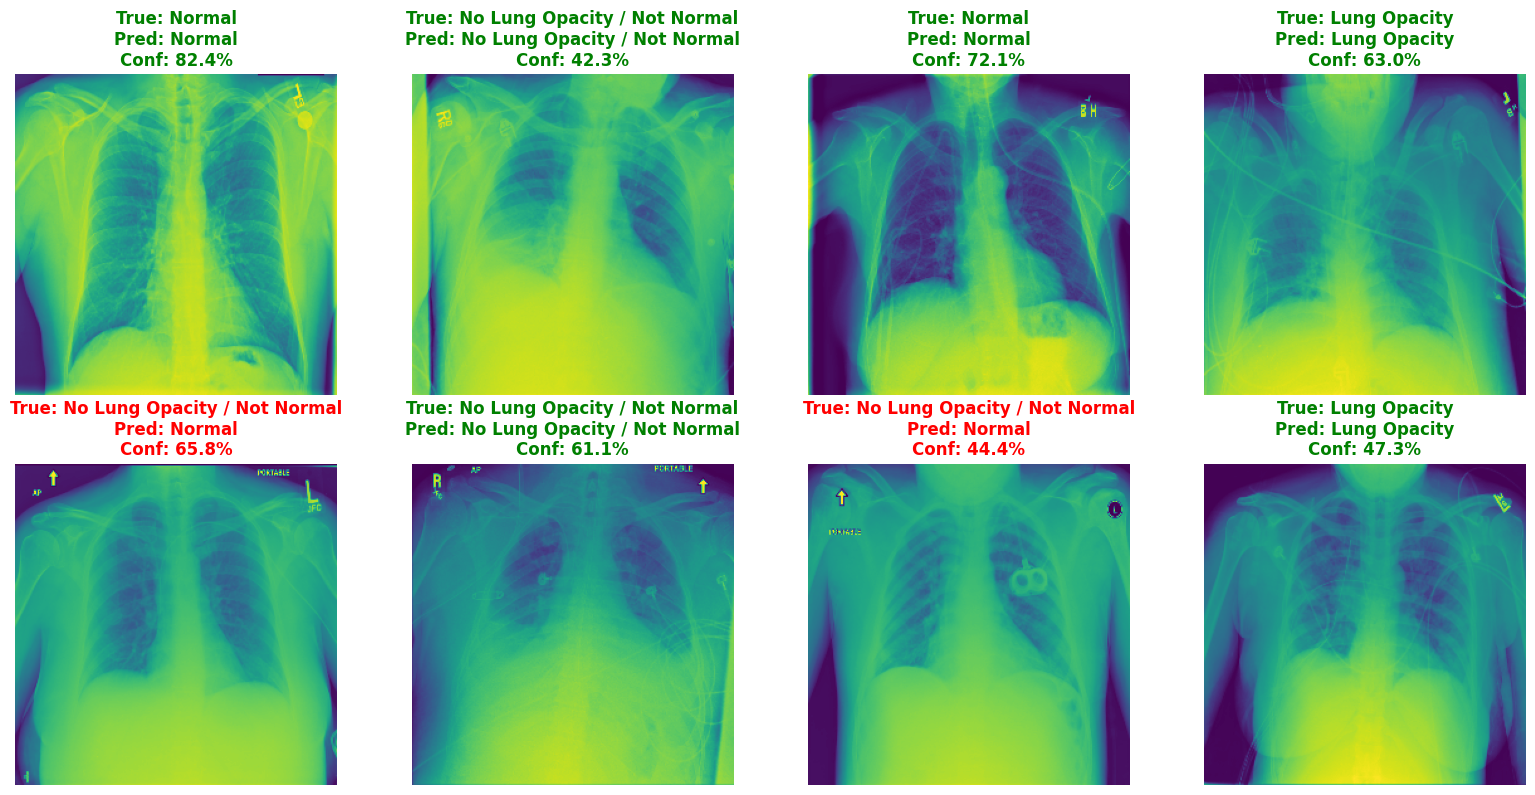

In [77]:
# Display predictions
display_sample_predictions(lenet5_model, lenet5_val_gen, le)

In [78]:
#Train and Evaludate Deep CNN model
deepcnn_model, deepcnn_history, deepcnn_val_gen = trainer.train_model(model_type='DeeperCNN', epochs=10)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,923 (50.48 MB)

 Trainable params: 13,233,923 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

None
Training: DeeperCNN
Epoch 1/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4639 - loss: 1.0197
Epoch 1: val_accuracy improved from -inf to 0.58078, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 1371s 2s/step - accuracy: 0.4640 - loss: 1.0197 - val_accuracy: 0.5808 - val_loss: 0.9219 - learning_rate: 1.0000e-04
Epoch 2/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5682 - loss: 0.8941
Epoch 2: val_accuracy improved from 0.58078 to 0.61070, saving model to pneumonia_model_best.keras
755/755 ━━━━━━━━━━━━━━━━━━━━ 1558s 2s/step - accuracy: 0.5682 - loss: 0.8940 - val_accuracy: 0.6107 - val_loss: 0.8855 - learning_rate: 1.0000e-04
Epoch 3/10
755/755 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5863 - loss: 0.8607
Epoch 3: val_accuracy did not improve from 0.61070
755/755 ━━━━━━━━━━━━━━━━━━━━ 1337s 2s/step - accuracy: 0.5863 - loss: 0.8607 - val_accuracy: 0.6077 - val_loss: 0.8651 - learning_rate: 1.0000e-04
Epoch 4/10
755/755 ━━━━━━━━━━━━━━

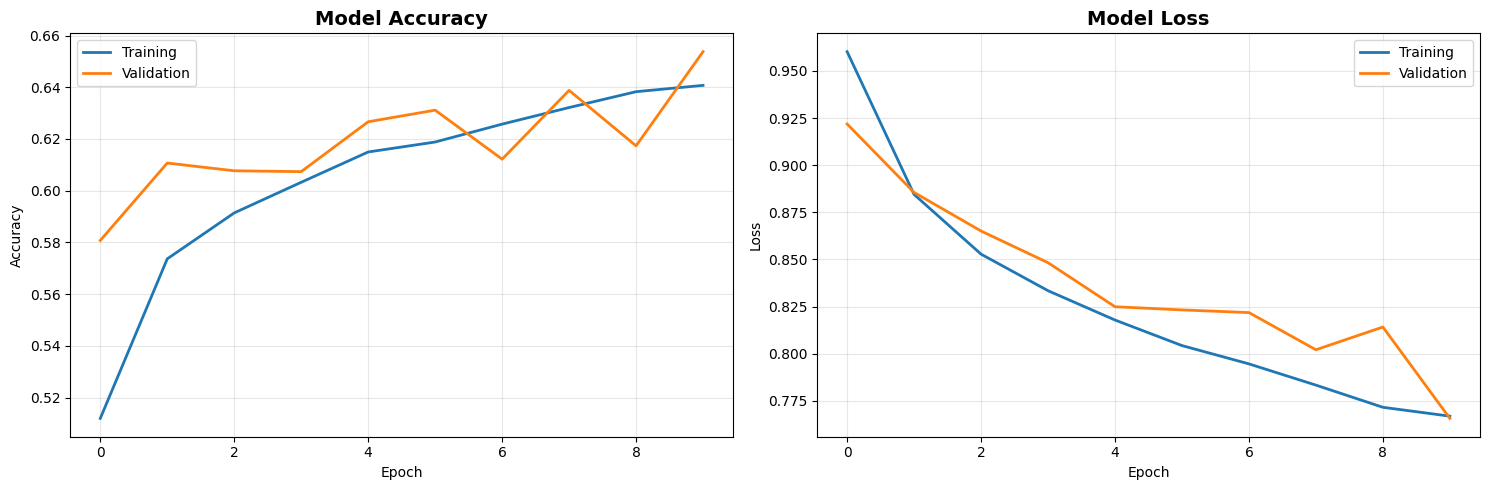

In [79]:
# Plot training history
plot_training_history(deepcnn_history)

Evaluating model performance...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Successfully processed 6016 samples from 188 batches

Classification Report:
                              precision    recall  f1-score   support

                Lung Opacity     0.7318    0.5710    0.6415      1902
No Lung Opacity / Not Normal     0.5659    0.6664    0.6120      2353
                      Normal     0.7240    0.7240    0.7240      1761

                    accuracy                         0.6531      6016
                   macro avg     0.6739    0.6538    0.6592      6016
                weighted avg

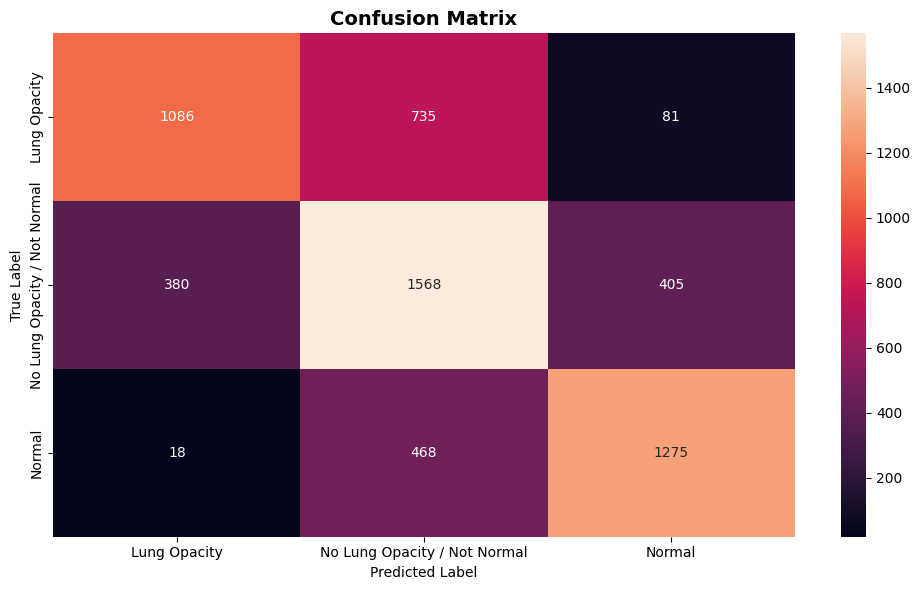

In [80]:
# Evaluate model using label encoder
y_true, y_pred = evaluate_model(deepcnn_model, deepcnn_val_gen, le)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


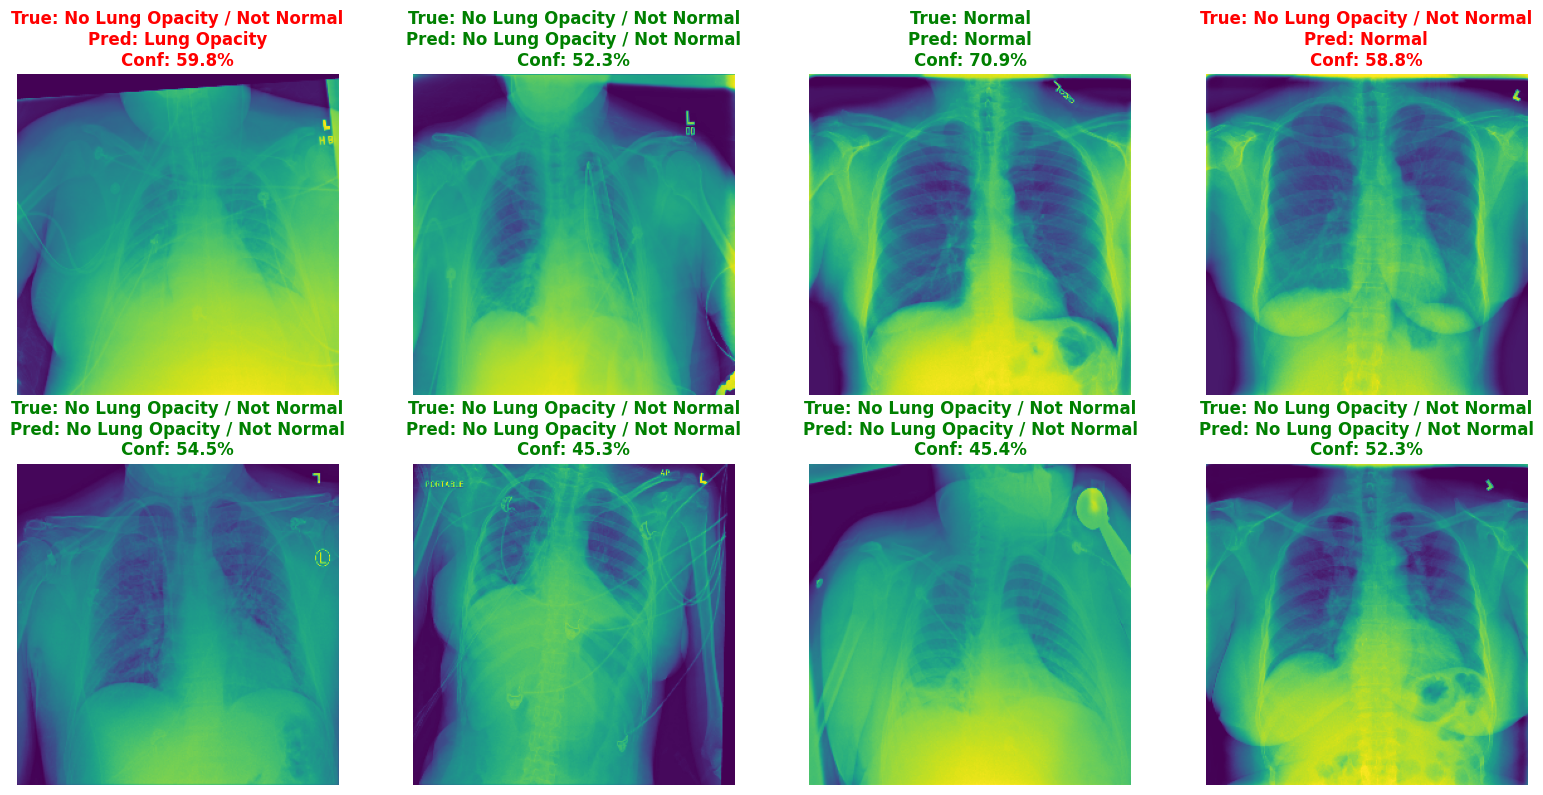

In [81]:
# Display predictions
display_sample_predictions(deepcnn_model, deepcnn_val_gen, le)

### **Observations & Insights**

#### **Basic Model**

**Observations:**

- Performance improved notably, especially in correctly classifying Lung Opacity.
- Confusion between Lung Opacity and No Lung Opacity suggests:
  - Need for clearer, more distinctive feature extraction.
  - Possible visual similarity between some X-ray images.

---

#### **MobileNet Model**

**Observations:**

- High precision on some classes (e.g., "Normal").
- Lower recall and F1-score on important classes (e.g., "Lung Opacity").
- Training loss decreases steadily, but validation loss plateaus or increases.
- Training accuracy much higher than validation accuracy.
- Evidence of overfitting and poor generalization.

---

#### **LesNet Model**

**Observations:**

- Good recall for Normal and No Lung Opacity classes.
- High precision for Lung Opacity, but recall is relatively lower.
- Lung Opacity classification becomes more balanced—precision and recall both close to 0.90.

---

#### **DeepCNN Model**

**Observations:**

- Some categories strongly outperform others.
- Distribution reveals strengths and areas needing improvement.
- Strong performers can guide focus and benchmarking.
- Weak areas require targeted training or resource allocation.
- Low correlations suggest independence.
- Useful for feature selection, avoiding multicollinearity, identifying key drivers, and risk assessment.

